<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/issue/%E6%9C%AA%E5%AE%8C%E6%88%90C620%E5%88%86%E6%9E%90%E5%AF%A6%E9%A9%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [2]:
from sklearn.metrics import r2_score,mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

def mape(y_true, y_pred, e = 1e-8):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  mask = y_true > e
  y_true, y_pred = y_true[mask], y_pred[mask]
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_real,y_pred,e=1e-8):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','MSE','MAPE'])
  for i in y_pred.columns:
    res.loc[i,'R2'] = np.clip(r2_score(y_real[i],y_pred[i]),0,1)
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i],e)
  res.loc['AVG'] = res.mean(axis=0)
  return res

# data

In [3]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0).dropna(axis=0)
c620_df_real = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
print(c620_df.shape)
c620_df.head(3)

(15552, 420)


,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# def columns

In [4]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
op_col = c620_df_real[op_col].dropna(axis=1).columns.tolist()
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
y_col = sp_col + op_col
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]
for idx in n_idx:
  assert np.allclose(c620_df[y_col].iloc[:,idx].sum(axis=1),1.0) # check
print(len(x_col),len(y_col))

44 172


In [5]:
c620_df.loc[['001-002', '001-005', '001-008', '001-011', '001-014'],
            x_col+y_col].to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/Data_format_example/c620_data.xlsx')

# lasso

In [6]:
from sklearn.model_selection import train_test_split
X = c620_df[x_col]
y = c620_df[op_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = linear_model.MultiTaskLasso(alpha=1e-2)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9921235280569529

In [8]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred,index=X_test.index,columns=y_test.columns)
show_metrics(y_test,y_pred)

,R2,MSE,MAPE
Density_Feed Properties,1,6.57407e-13,5.70456e-05
Density_Vent Gas Production Rate and Composition,0.964772,7.85358e-07,0.134288
Density_Distillate Production Rate and Composition,0.910978,9.58824e-06,0.293354
Density_Sidedraw Production Rate and Composition,0.999777,2.53745e-10,0.00137839
Density_Bottoms Production Rate and Composition,0.998701,2.17131e-11,0.000483626
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.992441,1.00302,0.602451
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.958026,0.0558589,0.119674
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.996236,0.00297389,0.023134
AVG,0.977616,0.132732,0.146853


#transferlearning

In [9]:
X = c620_df_real[x_col]
y = c620_df_real[op_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model.set_params(warm_start = True)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.42847031505292915

In [20]:
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred,index=X_test.index,columns=y_test.columns)
res = show_metrics(y_test,y_pred)
res

,R2,MSE,MAPE
Density_Feed Properties,0,6.50091e-05,0.203668
Density_Vent Gas Production Rate and Composition,0,2.85854e-15,7.82369e-06
Density_Distillate Production Rate and Composition,0.824023,3.09014e-06,0.164431
Density_Sidedraw Production Rate and Composition,0.259209,8.19217e-07,0.0560136
Density_Bottoms Production Rate and Composition,0.55336,2.23177e-07,0.049569
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.510293,11.6243,2.3991
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.212663,6.25969,1.19777
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.281194,1.1053,0.371129
AVG,0.330093,2.37367,0.555211


# HIST

Density_Feed Properties r2: 0.0


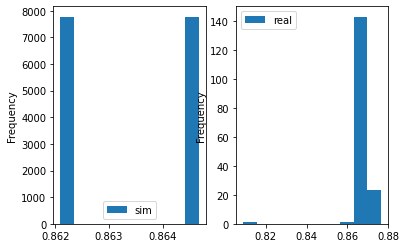

Density_Vent Gas Production Rate and Composition r2: 0.0


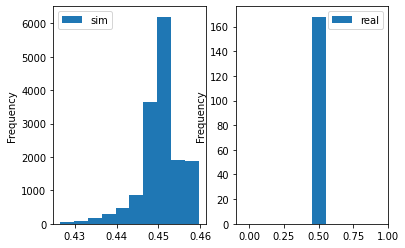

Density_Distillate Production Rate and Composition r2: 0.8240233278865704


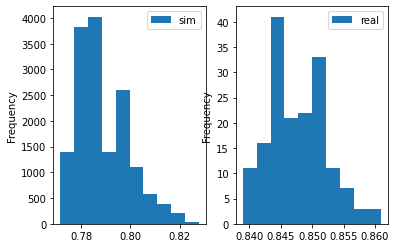

Density_Sidedraw Production Rate and Composition r2: 0.25920877257037156


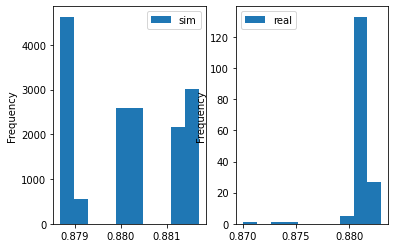

Density_Bottoms Production Rate and Composition r2: 0.5533603556798208


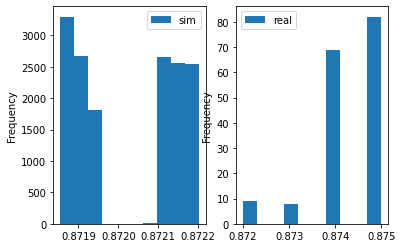

Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr r2: 0.5102930461789383


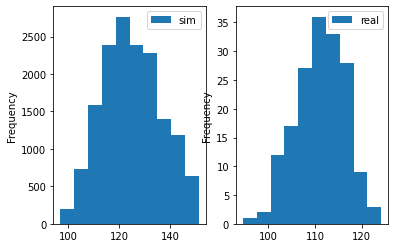

Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC r2: 0.21266320021567064


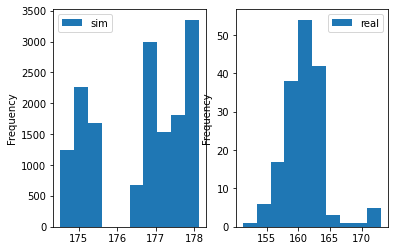

Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC r2: 0.28119377319695715


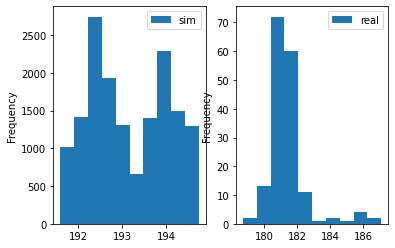

In [21]:
import matplotlib.pyplot as plt
for i in op_col:
  print(i,'r2:',res.loc[i,'R2'])
  plt.figure()
  plt.subplot(121)
  c620_df[i].plot(kind='hist',label='sim')
  plt.legend()
  plt.subplot(122)
  c620_df_real[i].plot(kind='hist',label='real')
  plt.legend()
  plt.show()

# CORR

In [27]:
c620_df[x_col+op_col].corr().loc[x_col,op_col]

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,0.000002,0.578463,0.581056,0.008586,-0.000360,0.000528,0.020528,0.027283
Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,-0.039150,-0.789256,0.741025,-0.028176,-0.063635,-0.310846,0.012044,0.015240
Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,-0.000013,0.074062,-0.069393,0.994226,-0.210876,0.531349,-0.961551,-0.340839
Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,-0.999944,-0.115129,0.155050,-0.100487,-0.969448,-0.455335,-0.113341,0.899324
Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,-0.999974,-0.114910,0.154883,-0.100321,-0.969468,-0.455011,-0.113461,0.899382
Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,-0.999753,-0.117514,0.156104,-0.100573,-0.972535,-0.475289,-0.117552,0.891206
Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,-0.984147,-0.129302,0.160076,-0.100220,-0.974735,-0.575428,-0.137701,0.835044
Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,-0.533009,-0.136259,0.118027,-0.060574,-0.611716,-0.830969,-0.180252,0.248518
Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,-0.528270,-0.136974,0.118262,-0.061050,-0.607191,-0.830814,-0.179077,0.244042


In [28]:
c620_df_real[x_col+op_col].corr().loc[x_col,op_col]

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,0.232360,2.205345e-15,0.412054,0.060130,-0.147889,0.385767,-0.079853,0.158178
Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,0.040358,-6.853515e-17,0.026945,-0.000453,-0.137054,0.074434,0.013504,-0.077722
Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,-0.122816,6.625427e-15,0.015437,0.288597,-0.025439,0.081023,-0.374881,-0.146561
Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,-0.271322,1.730188e-15,-0.524317,0.174046,0.540418,0.095297,-0.181703,-0.401812
Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,-0.271322,-5.395460e-16,-0.524317,0.174046,0.540418,0.095297,-0.181703,-0.401812
Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,-0.272267,2.266385e-15,-0.539736,0.167516,0.538625,0.116829,-0.181403,-0.401304
Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,-0.267250,-4.311065e-16,-0.598094,0.128571,0.510235,0.221205,-0.173373,-0.384326
Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,-0.156502,-9.656620e-16,-0.547520,-0.028272,0.245465,0.437210,-0.087990,-0.197381
Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,-0.163328,1.347377e-15,-0.556298,-0.021578,0.260252,0.432727,-0.092863,-0.208108


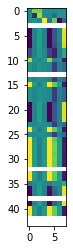

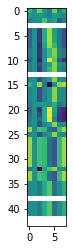

In [31]:
plt.imshow(c620_df[x_col+op_col].corr().loc[x_col,op_col].values)
plt.show()
plt.imshow(c620_df_real[x_col+op_col].corr().loc[x_col,op_col].values)

In [33]:
c620_df[x_col+op_col].corr().loc[x_col,op_col].values.shape

(44, 8)